# Convolutional Neural Network

### Importing the libraries

In [1]:
import tensorflow as tf
# keras is high level api for tensorflow
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.__version__

'2.13.0'

## Part 1 - Data Preprocessing

### Preprocessing the Training set

In [3]:
# The first thing we need to do is to apply transformation
# Benefits: increase dataset size, reduce overfitting, and improve model robustness since real world image tends to be more varied

# what transformations? answer: some zoom/rotations/flips, apply geometrical transformation like "transvections" to get them "augmented" - the proper term for this is called image augmentation (i.e. augment the variety of images to prevent overfitting)

# generate batches of tensor image data with real time data augmentation - create batches of 32 images
# https://keras.io/zh/preprocessing/image/
train_datagen = ImageDataGenerator(
    # This rescales the image pixel values. Since the original pixel values range from 0 to 255 (for RGB color images), this operation normalizes the pixel values to be between 0 and 1, which is a common practice in image processing to facilitate neural network training.
    # It's similar to the feature scaling step we did in ANN
    rescale = 1/255,
    # This applies random shearing transformations. In shearing, the image is slanted either horizontally or vertically. A shear range of 0.2 allows for a moderate amount of shearing.
    shear_range = 0.2,
    # This applies random zooming inside the pictures. A zoom range of 0.2 allows the images to be randomly zoomed in or out by up to 20%
    zoom_range = 0.2,
    # This enables random flipping of images horizontally (left to right). This is often used for data augmentation when the dataset doesn't have a specific orientation.
    horizontal_flip = True)

# flow_from_directory: This function takes the path to a directory & generates batches of augmented data.
training_set = train_datagen.flow_from_directory('dataset/training_set',
    # This specifies the dimensions to which all images found will be resized. In this case, images will be resized to 64x64 pixels.
    # why 64x64? Answer: to reduce the computational complexity without losing much information; our CNN can still be quite performant (+the tutor tried with 150 by 150 and that took way too long)
    target_size = (64, 64),
    # This determines the size of the batches of data (number of images). Here, 32 images will be processed at a time.
    # why 32? Batch sizes like 32, 64, 128 are common because they often strike a good balance between efficient computation (using powers of 2 fits well with computer memory architecture) and model performance.
    # Smaller batches tend to offer better generalization (reduction in overfitting), while larger batches can speed up the training process. However, very large batches might lead to poor convergence properties during optimization.
    batch_size = 32,
    # This indicates that there are only two classes to be predicted, so the labels will be binary.
    class_mode = 'binary')

Found 8000 images belonging to 2 classes.


### Preprocessing the Test set

In [4]:
# same feature scaling as before (to keep things consistent)
test_datagen = ImageDataGenerator(rescale = 1/255)
# apply the same dataset to generate batches of images (resized to be 64x64), again, to keep things consistent
test_set = test_datagen.flow_from_directory('dataset/test_set',
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'binary')

# My Question: how do they know which image is for dog and which image is for cat? We didn't have "labels".t
# Answer: the flow_from_directory method automatically label the images based on the subdirectories. In this case, the subdirectories in dataset/test_set are /cats and /dogs, so they would label the corresponding images in those folder as the labels itself

#  Don't believe me? See this code. It shows the labels they extracted.
test_set.class_indices.keys()


Found 2000 images belonging to 2 classes.


dict_keys(['cats', 'dogs'])

## Part 2 - Building the CNN

### Initialising the CNN

In [5]:
# CNN, just like ANN, is still consisting of sequence of layers
# In Keras, a Sequential model is a linear stack of layers. It's one of the simplest ways to build a model in Keras, allowing you to add layers one by one in sequence.
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution

In [6]:
# ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
# tf.keras.layers.Conv2D(...): This specifies that the layer being added is a 2D convolutional layer, which is commonly used in processing images in CNNs.
# filters=32: This sets the number of filters (or kernels) to 32. In the context of CNNs, filters are used to extract features from the input image. Each filter is capable of detecting a specific type of feature (like edges, textures, etc.) at various locations in the input image. Here, we have 32 filters.
    # why 32? Answer: it's a common practice to start with 16, 32, or 64 filters in the first convolutional layer, and then double the number of filters in each subsequent convolutional layer (64, 128, 256, etc.).
# kernel_size=3: This sets the dimensions of the filter kernel. Here, the kernel/filter is 3x3 pixels.
# activation='relu': This rectified linear unit function introduces non-linearity to the model, allowing it to learn more complex patterns.
# input_shape: Everytime we specify our first layer, we need to indicate the input data shape. Here, it's set to [64, 64, 3], which implies that the input images are 64x64 pixels in size with 3 channels (typically corresponding to the RGB color channels). - if we're working with black and white images, it'd be 64x64x1
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))

### Step 2 - Pooling

Pool Size = 2: 

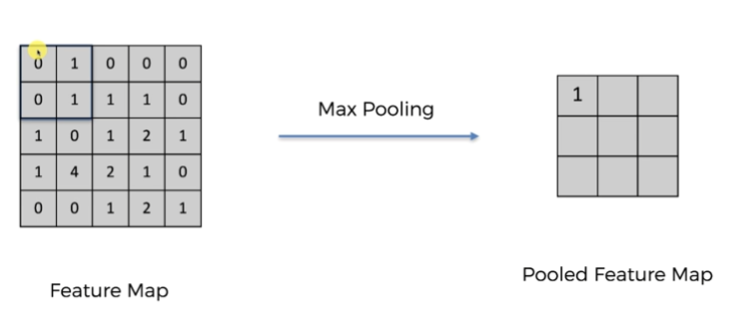

Stride = 2

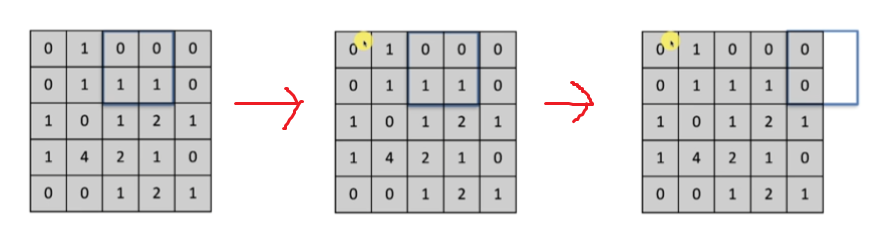

In [7]:
# This line adds a 2D Max Pooling layer to the CNN. Max Pooling is a downsampling strategy used in CNNs to reduce the spatial dimensions (i.e., width and height) of the input volume for the next convolutional layer.

# pool_size=2: This sets the size of the pooling window to 2x2. The pool size determines the region over which the maximum value will be computed. A pool size of 2 means that the maximum value will be selected from each 2x2 region of the input.

# strides=2: The stride determines the step size of the pooling window as it moves over the input. A stride of 2 means that the pooling window will move 2 pixels across (and down) for each operation. This results in a reduction of the spatial dimensions of the input by a factor of 2 in both width and height.

cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a second convolutional layer

In [8]:
# the second convolutional layer doesn't need to have the input shape defined
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Step 3 - Flattening

In [9]:
cnn.add(tf.keras.layers.Flatten())

### Step 4 - Full Connection

In [10]:
# now we can add our ANN layers
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### Step 5 - Output Layer

In [11]:
# final output layer with 1 output neuron (either is dog or not dog, which means cat)
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Part 3 - Training the CNN

### Compiling the CNN

In [12]:
# the rationale is same as the ANN code portion
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Training the CNN on the Training set and evaluating it on the Test set

In [13]:
# output is /250 for each epoch because we have 8000 images and batch size of 32. 250 * 32 = 8000
# cnn.fit(x = training_set, validation_data = test_set, epochs=30)

### Saving The Model File

In [14]:
# save the model file
cnn.save('model.keras')

### Loading The Model File

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
cnn = load_model('model.keras')

## Part 4 - Making a single prediction

In [21]:
import numpy as np

# we need to resize the input image to 64x64 just like how we trained our model with images resized to 64x64
image_to_predict = image.load_img('dataset/single_prediction/cat2.jpeg', target_size=(64, 64))

# by default image.load_img loads a PIL format
# we can convert it to np array with img_to_array method
image_to_predict = image.img_to_array(image_to_predict)

# Rescale the image (consistent with training data preprocessing)
image_to_predict = image_to_predict / 255.0

# earlier we specify training set with batches, i.e. in flow_from_directory, we specified a field batch_size = 32.
# this means that there are 2 columns, 1 column referring to batch number like batch 1 batch 2, and another column containing the actual data
# so we now need to manipulate our np array to mirror that exact same two column setup by adding 1 more dimension
image_to_predict = np.expand_dims(image_to_predict, axis = 0)

# output of CNN
result = cnn.predict(image_to_predict)


print(result)
# ??? class indices.
training_set.class_indices

# since we have 1 column for batch and 1 column for value, we need to access result like this
if result[0][0] > 0.5:
  prediction = 'dog'
else:
  prediction = 'cat'

print('The CNN prediction is', prediction)

1/1 [==============================] - 0s 15ms/step
[[0.00259954]]
The CNN prediction is cat
